In [10]:
import torch
import sys
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from PyPDF2 import PdfReader
import shutil
from PIL import Image, ImageSequence
from pdf2image import convert_from_path
from models.experimental import attempt_load
from utils.general import non_max_suppression
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torchvision import datasets, models
import logging
import datetime

# 設定 log 檔
logging.basicConfig(filename='error.log', level=logging.ERROR)
# 獲取當前時間
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# 讀取資料夾位置
file_path = "datasets/rotation"

# STEP 1 分類模型參數
IMAGE_FILE = 'datasets/Fail/2023-06-29/不同意通過誤判/B3100420230629002470/fsB3100420230629002470_0_0-2.pdf'
# #STEP1.1 圖片翻轉標準圖片
P_template_path = 'datasets/template/P_template.jpg'
E_template_path = 'datasets/template/E_template.jpg'
# #STEP1.2 合約書類型確認
type_recognition_pth = "weights/recognition_type.pth"



# STEP 2 物件偵測參數
#DEVICE = torch.device("cpu") # cpu / torch.device(0)
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conf_threshold = 0.4
CLASSES = [ 'big','big_none','small','small_none','signature','signature_none','Checked',
'Unchecked','Contractor','Contractor_none','Representative','Representative_none',
'Company name','Company name_none','Bank name','Unified Business Number (UBN)','Unified Business Number (UBN)_none',
'ID','ID_none','codes','codes_none' ]
IMAGE_FILE_enterprise = 'datasets/E/E_test (2).jpg'
IMAGE_FILE_contractor = 'datasets/P/P_test (19).jpg'
WEIGHTS_enterprise_pt = "weights/enterprise_V2.pt"
WEIGHTS_contractor_pt = "weights/contractor_V2.pt"


#### 讀取TIFF檔案

In [2]:
# 判斷 TIFF/TIF 頁數
def count_tiff_pages(input_file):
    try:
        # 開啟 TIFF 檔案
       image = Image.open(input_file)

        # 獲取圖片數量（頁數）
       num_pages = image.n_frames
       
       return num_pages

    except Exception as e:
        print(f'讀取 TIFF 檔案失敗: {e}')


# 轉換 TIFF/TIF 檔案 TO JPG 
def convert_multi_page_tiff(input_file, output_prefix):
    try:
        # 開啟多頁 TIFF 檔案
        image = Image.open(input_file)

        # 使用 enumerate 迴圈逐頁處理
        for i, page in enumerate(ImageSequence.Iterator(image)):
            # 將圖片轉換為 RGB 格式
            page = page.convert('RGB')

            # 構造輸出檔案名稱
            output_file = f"{output_prefix}_{i+1}.jpg"

            # 儲存當前頁面為 JPG 格式
            page.save(output_file, 'JPEG')
    except Exception as e:
        print(f'轉換失敗: {e}')



#### 圖片轉正

In [4]:
def rotate_image(img, angle):
    # 旋轉圖片
    rotated_img = img.rotate(angle, expand=True)

    # 調整大小
    resized_img = rotated_img.resize(img.size, Image.ANTIALIAS)

    # 將圖片轉換為 NumPy array
    resized_img = np.array(resized_img)

    return resized_img

    
def correct_rotation(image_path, template_path):
    # 開啟圖片
    img = Image.open(image_path)
    # Load images
    image = cv2.imread(image_path)
    template = cv2.imread(template_path)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # Create ORB object
    orb = cv2.ORB_create()

    # Find keypoints and descriptors for image and template
    keypoints_image, descriptors_image = orb.detectAndCompute(gray_image, None)
    keypoints_template, descriptors_template = orb.detectAndCompute(
        gray_template, None)

    # Create brute-force matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_image, descriptors_template)

    # Filter good matches based on Lowe's ratio test
    good_matches = []
    for match in matches:
        if match.distance < 0.7 * match.trainIdx:
            good_matches.append(match)

    # Get matching keypoints' coordinates
    src_pts = np.float32(
        [keypoints_image[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [keypoints_template[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimate affine transformation matrix using RANSAC
    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)

    # Calculate rotation angle from transformation matrix
    angle = np.arctan2(M[1, 0], M[0, 0]) * 180 / np.pi

    # Rotate the image to correct the rotation
    rotated_image = rotate_image(img, -angle)
    # 將BGR轉換為RGB
    #rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)

    return rotated_image

#### 圖片對半裁剪只留下半部

In [5]:
def crop_image_bottom_half(img):
    #img = cv2.imread(image_path)
    height, width = img.shape[:2]
    cropped_img = img[height//2:height, :]
    return cropped_img

#### 圖片對半裁剪只留上半部

In [6]:
def crop_image_top_half(img):
    #img = cv2.imread(image_path)
    height, width = img.shape[:2]
    cropped_img = img[0:height//2, :]
    return cropped_img

#### 儲存出現異常的照片

In [7]:
def save_error_image(image,IMAGE_FILE, folder_name):
    error_images_dir = os.path.join("datasets/defect", folder_name)  # 定義保存錯誤圖片的目錄
    os.makedirs(error_images_dir, exist_ok=True)  # 確保目錄存在

    # 生成新的檔名
    base_name = os.path.basename(IMAGE_FILE)
    error_image_name = f"error_{current_datetime}_{base_name}"
    error_image_path = os.path.join(error_images_dir, error_image_name)
    #print('check',error_image_path)
    # 儲存錯誤的圖片
    cv2.imwrite(error_image_path, image)
    print(f"Saved error image: {error_image_path}")
    logging.error("[%s] Saved error image: %s" %  (current_time,error_image_path) )

#### STEP 1 分類

In [8]:
def classification(IMAGE_FILE,recognition_pth,num_classes = 2,class_names = ['contractor', 'enterprise'] ):
    # 定義預處理操作，這些操作需要與訓練時一致
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
    # 載入預訓練模型
    model = models.resnet18()  
    model.fc = torch.nn.Linear(512, num_classes)  # 修改最後一層全連接層的形狀
    # 載入模型權重
    checkpoint = torch.load(recognition_pth, map_location=DEVICE)  # 載入模型權重檔案
    if 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint)
    # 切換模型為評估模式
    model.eval()
    # 讀取圖片並進行預處理
    image = Image.open(IMAGE_FILE)  # 讀取圖片
    image = preprocess(image)  # 進行預處理
    image = image.unsqueeze(0)  # 增加 batch 維度

    # 使用模型進行推論
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # 將模型輸出轉換為機率分佈
        _, predicted = torch.max(probabilities, 1)
        predicted_label = predicted.item()
        predicted_probabilities = probabilities.squeeze().numpy()  # 將機率值轉換為 NumPy 陣列
    predicted_class = class_names[predicted_label]
    return predicted_class,predicted_probabilities[predicted_label]

In [11]:
#分辨合約類型
classification(IMAGE_FILE,type_recognition_pth,num_classes = 2,class_names = ['contractor', 'enterprise'])

UnidentifiedImageError: cannot identify image file 'datasets/Fail/2023-06-29/不同意通過誤判/B3100420230629002470/fsB3100420230629002470_0_0-2.pdf'

#### STEP 2 物件偵測

In [12]:
def predict(image,model, image_size=640):
    image = np.asarray(image)
    
    # Resize image to the inference size
    ori_h, ori_w = image.shape[:2]
    pil_image = Image.fromarray(image)
    pil_image = pil_image.resize((image_size, image_size), resample=Image.BICUBIC)  #選擇pil_image 避免圖片變形較嚴重
    image = np.array(pil_image)


    # Transform image from numpy to torch format
    image_pt = torch.from_numpy(image).permute(2, 0, 1).to(DEVICE)
    image_pt = image_pt.float() / 255.0
    
    # Infer
    with torch.no_grad():
        pred = model(image_pt[None], augment=True)[0]  #augment=True 測試時間擴增（Test Time Augmentation, TTA），推論過程中使用多種資料擴增技術，最終取多次預測的平均值來得到最終結果
    # NMS
    pred = non_max_suppression(pred,iou_thres=0.15)[0].cpu().numpy()
    # Resize boxes to the original image size
    pred[:, [0, 2]] *= ori_w / image_size
    pred[:, [1, 3]] *= ori_h / image_size
    return pred

In [13]:
def object_detection_enterprise(image_enterprise,WEIGHTS_enterprise_pt):
    model_enterprise = attempt_load(WEIGHTS_enterprise_pt, map_location=DEVICE) 
    result = []
    # 讀圖片
    #image_enterprise = cv2.imread(IMAGE_FILE_enterprise)
    image_enterprise = image_enterprise.astype('uint8')
    # 將圖片轉換為RGB通道順序
    image_enterprise = cv2.cvtColor(image_enterprise, cv2.COLOR_BGR2RGB)
    image_enterprise_ori = image_enterprise.copy()
    # 偵測結果
    pred1 = predict(image_enterprise,model_enterprise)
    max_conf = {}
    for x1, y1, x2, y2, conf, class_id in pred1:
        print(' x1, y1, x2, y2, conf, class_id', x1, y1, x2, y2, conf, CLASSES[int(class_id)])
        if conf >= conf_threshold:
            # 隨機生成顏色
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cropped_image = image_enterprise_ori[int(y1):int(y2), int(x1):int(x2), :]
            cv2.rectangle(image_enterprise, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.putText(image_enterprise, CLASSES[int(class_id)], (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
            # 針對特定class 做截圖
            if CLASSES[int(class_id)] == 'Unified Business Number (UBN)':
                cropped_image = image_enterprise_ori[int(y1):int(y2), int(x1-50):int(x2+50), :]
                # cv2.imshow('test', cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()
            elif CLASSES[int(class_id)] == 'ID':
                cropped_image = image_enterprise_ori[int(y1):int(y2), int(x1-50):int(x2+50), :]
                # cv2.imshow('test', cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()
            class_name = CLASSES[int(class_id)] 
            if class_name.endswith('_none'):
                compare_id = class_name[:-5]
            elif class_name == 'Checked':
                compare_id = 'Unchecked'
            else:
                compare_id = class_name
            if compare_id in max_conf:
                if conf > max_conf[compare_id]['conf']:
                    max_conf[compare_id] = {'class_id': class_name, 'conf': conf}
            else:
                max_conf[compare_id] = {'class_id': class_name, 'conf': conf}
    print(max_conf)
    for entry in max_conf.values():
        print(entry['class_id'], entry['conf'])
        result.append(entry['class_id'])
    # 顯示圖片
    plt.figure(figsize=(40, 32))
    plt.imshow(image_enterprise)
    plt.axis('off')  # 不顯示座標軸
    plt.show()
    return result

In [14]:
# 對照範例樣本有歪斜會自動翻轉
corrected_image = correct_rotation('datasets/tiff/output_1.jpg', E_template_path)
# 圖片對半裁剪只留下半部
crop_bottom = crop_image_bottom_half(corrected_image)
# 企業合約書模型
object_detection_enterprise(crop_bottom,WEIGHTS_enterprise_pt)

crop_top = crop_image_top_half(corrected_image)
# 企業合約書模型
object_detection_enterprise(crop_top,WEIGHTS_enterprise_pt)

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/tiff/output_1.jpg'

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 x1, y1, x2, y2, conf, class_id 960.60895 578.40125 1314.5637 905.97424 0.9664284 big
 x1, y1, x2, y2, conf, class_id 1371.9047 728.7719 1573.624 914.0036 0.9508301 small
 x1, y1, x2, y2, conf, class_id 29.7546 722.71014 619.68536 807.61304 0.9075175 Unified Business Number (UBN)
 x1, y1, x2, y2, conf, class_id 53.552376 478.7159 116.6419 529.13086 0.9027479 Checked
 x1, y1, x2, y2, conf, class_id 30.241556 636.6292 617.85645 708.0972 0.86876154 Representative
 x1, y1, x2, y2, conf, class_id 30.895674 582.4867 618.1389 627.5552 0.86022145 Company name_none
 x1, y1, x2, y2, conf, class_id 40.46365 539.0952 644.5744 574.95416 0.38960254 Company name_none
{'big': {'class_id': 'big', 'conf': 0.9664284}, 'small': {'class_id': 'small', 'conf': 0.9508301}, 'Unified Business Number (UBN)': {'class_id': 'Unified Business Number (UBN)', 'conf': 0.9075175}, 'Unchecked': {'class_id': 'Check

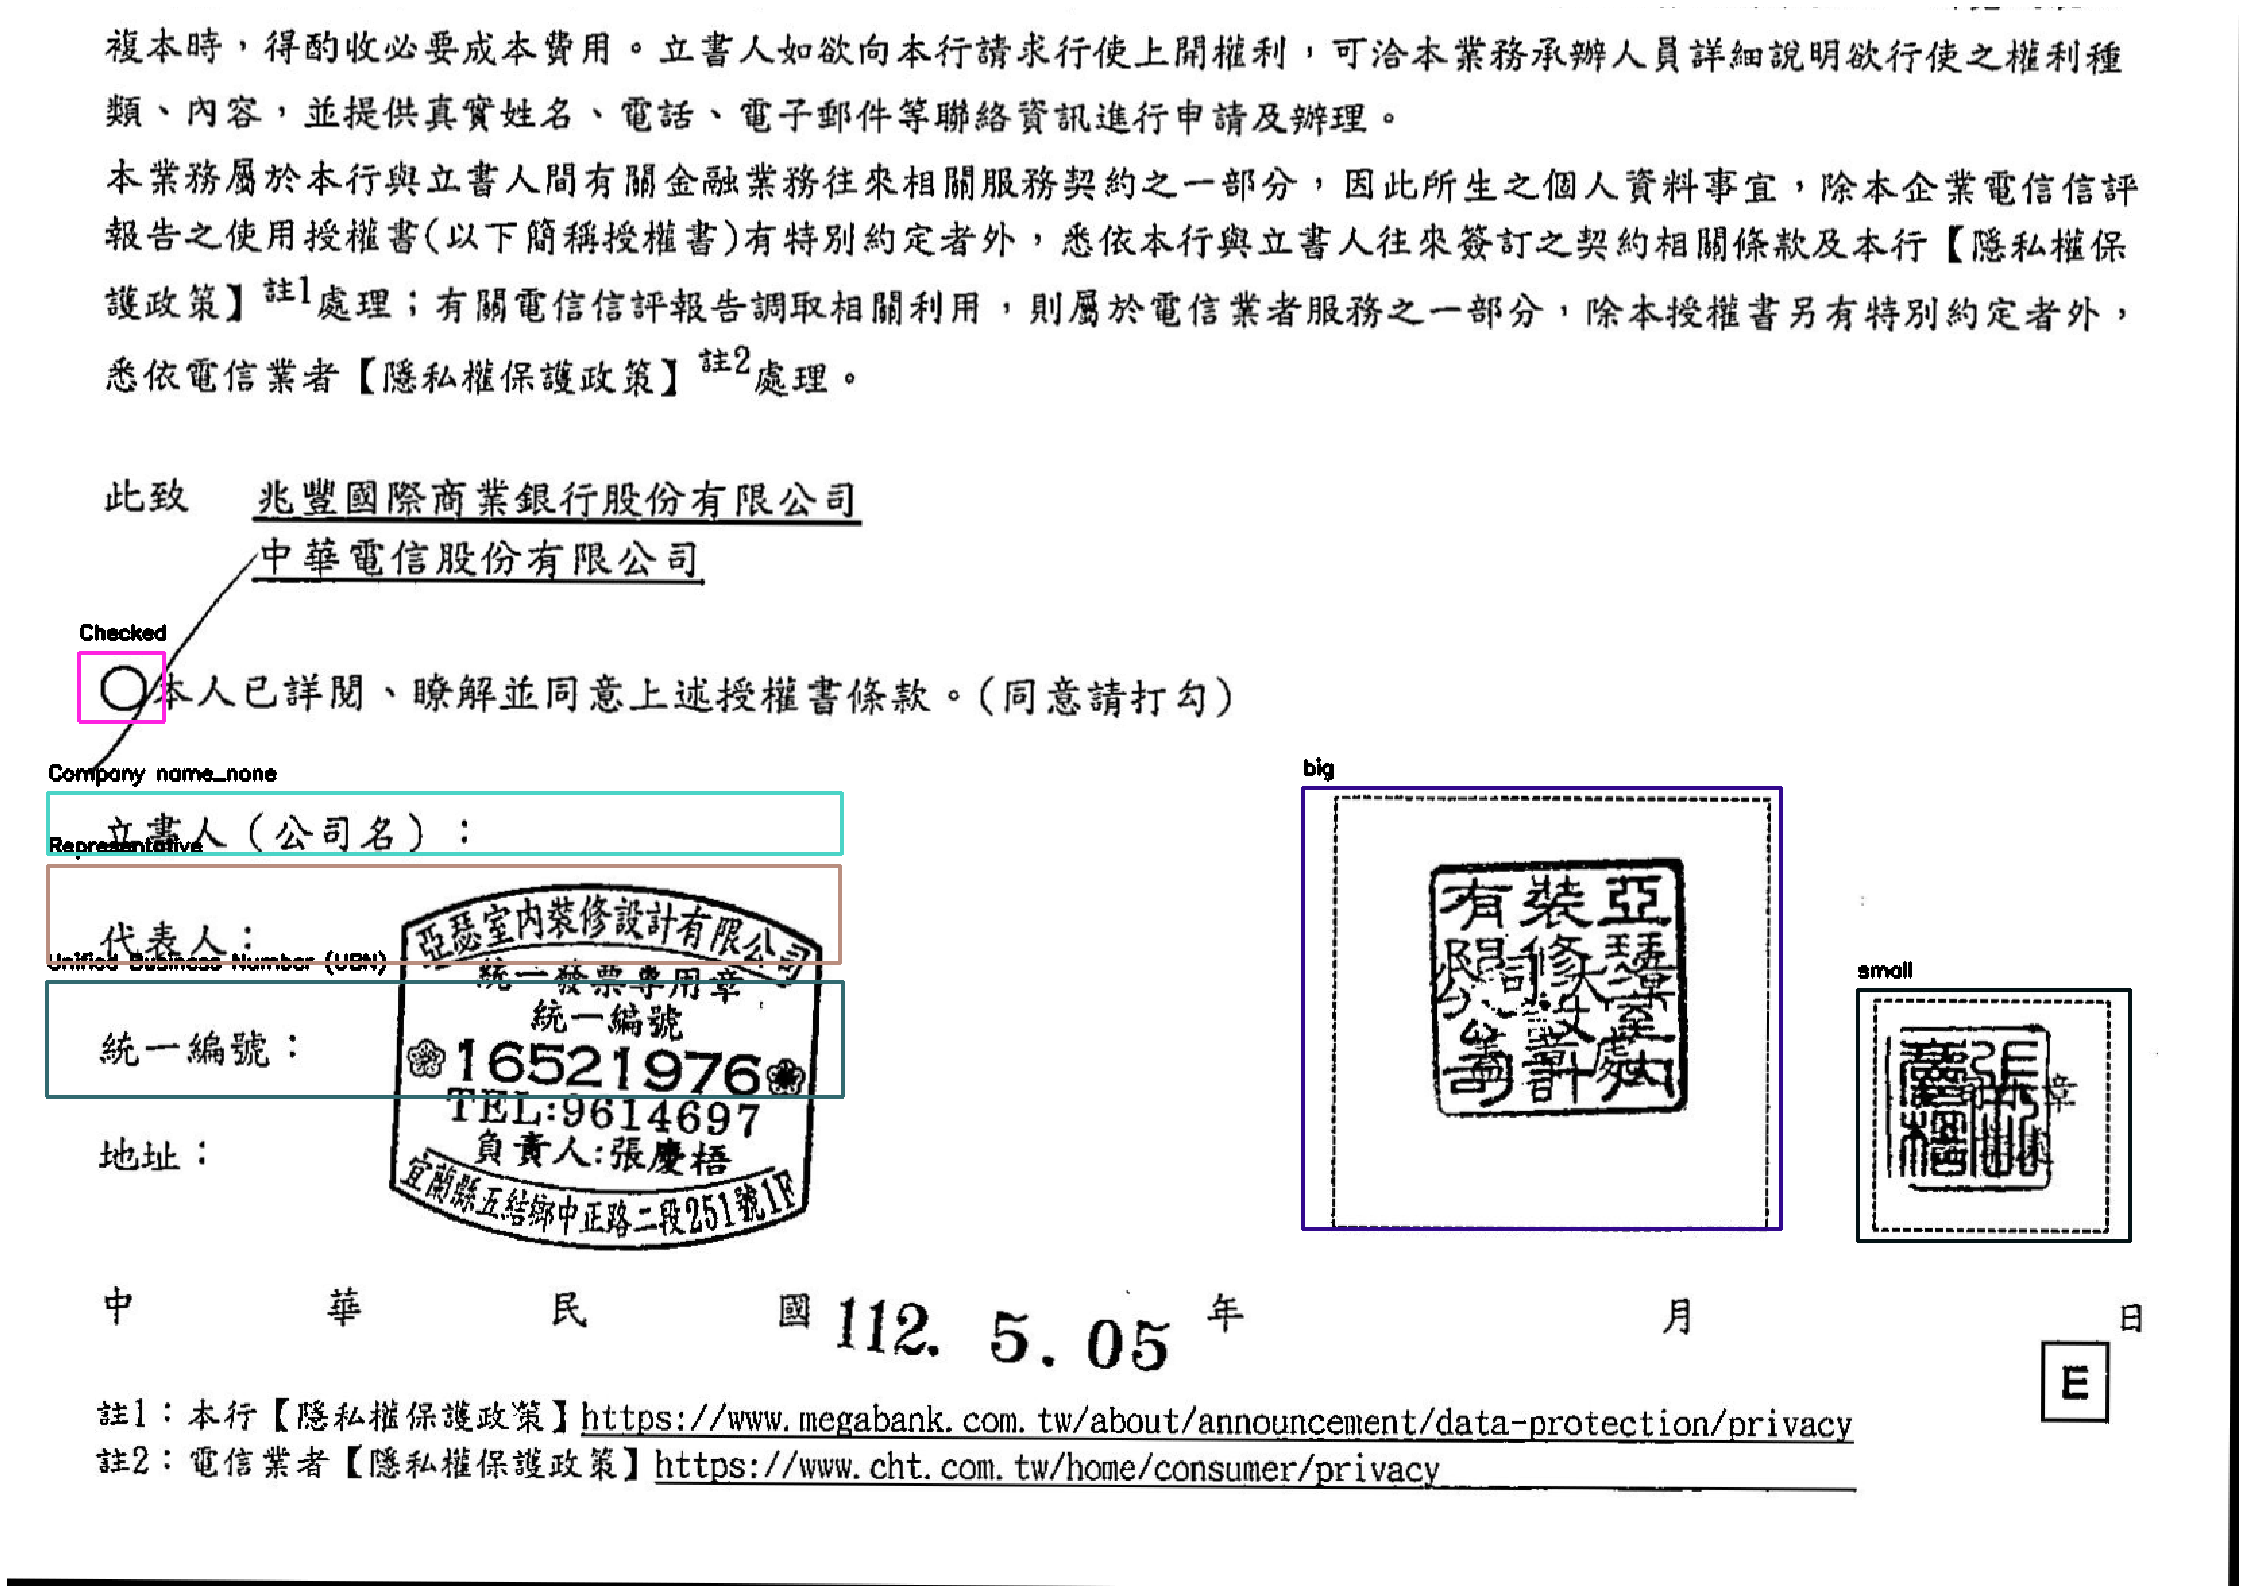

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 x1, y1, x2, y2, conf, class_id 1416.3848 269.03198 1570.0604 405.68808 0.9592096 small_none
 x1, y1, x2, y2, conf, class_id 1122.8773 159.83575 1379.5006 404.58118 0.9559701 big_none
 x1, y1, x2, y2, conf, class_id 68.985596 176.19064 128.05974 216.98355 0.43140906 Unchecked
{'small': {'class_id': 'small_none', 'conf': 0.9592096}, 'big': {'class_id': 'big_none', 'conf': 0.9559701}, 'Unchecked': {'class_id': 'Unchecked', 'conf': 0.43140906}}
small_none 0.9592096
big_none 0.9559701
Unchecked 0.43140906


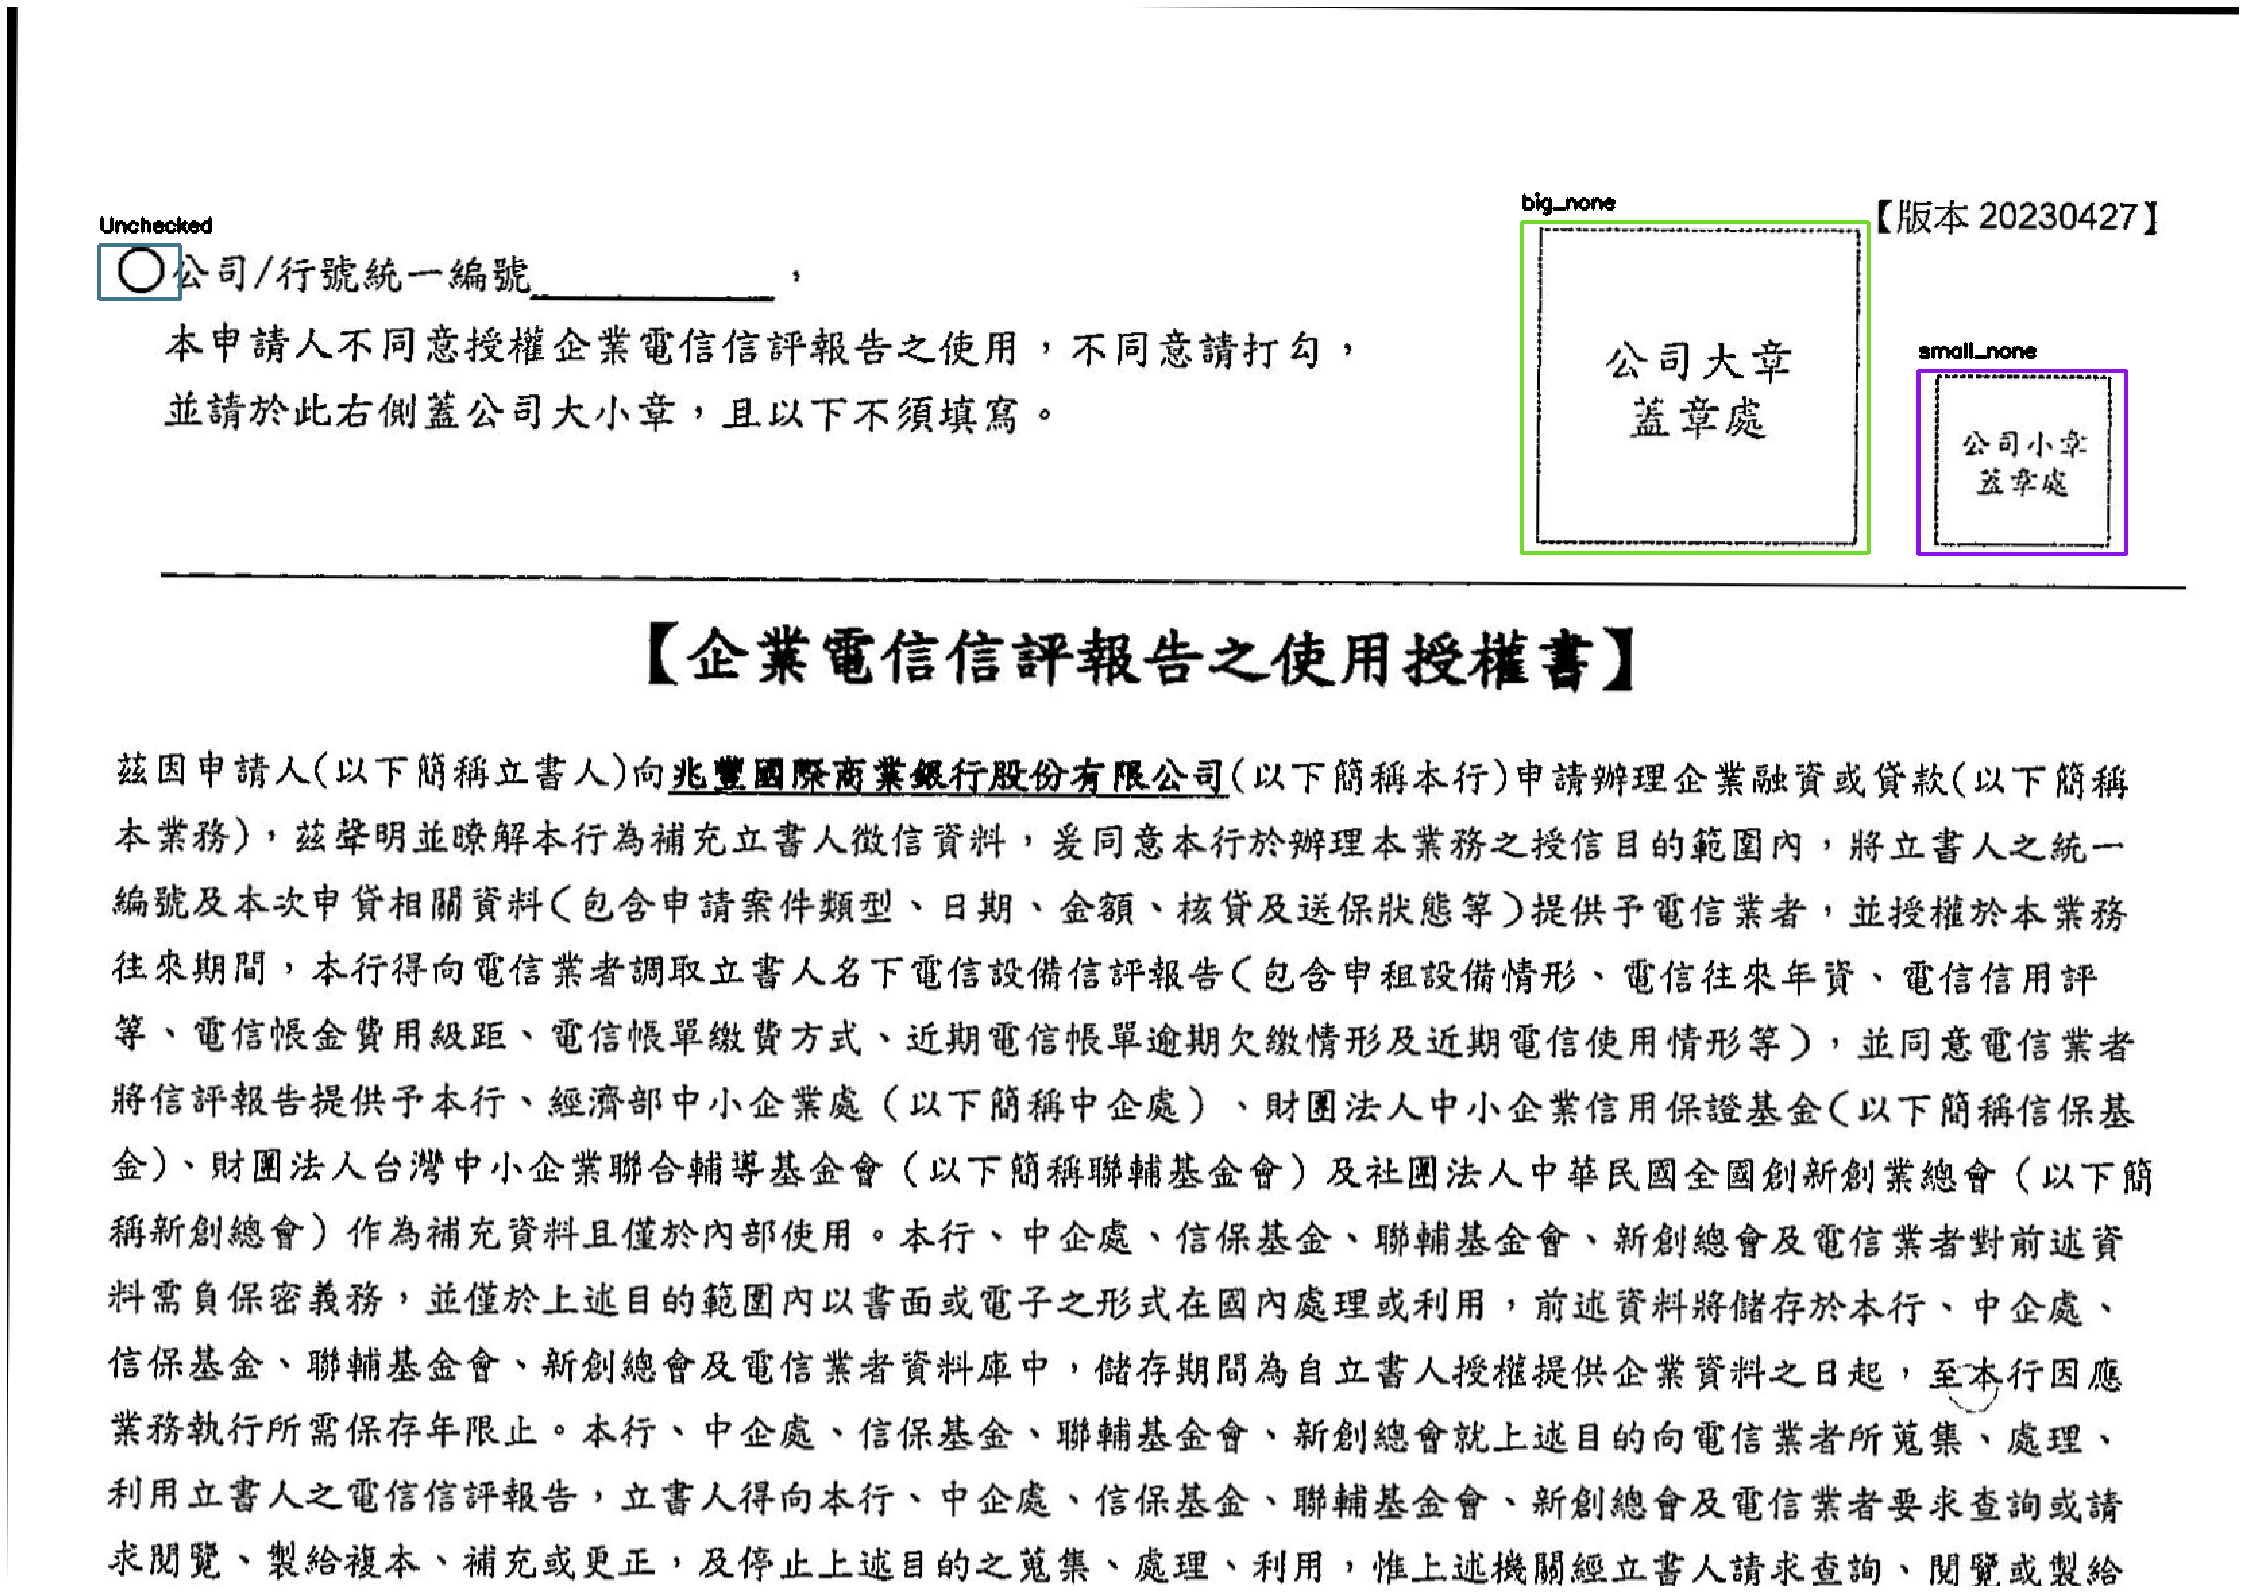

['small_none', 'big_none', 'Unchecked']

In [96]:
# 對照範例樣本有歪斜會自動翻轉
corrected_image = correct_rotation(IMAGE_FILE_enterprise, E_template_path)
# 圖片對半裁剪只留下半部
crop_bottom = crop_image_bottom_half(corrected_image)
# 企業合約書模型
object_detection_enterprise(crop_bottom,WEIGHTS_enterprise_pt)

crop_top = crop_image_top_half(corrected_image)
# 企業合約書模型
object_detection_enterprise(crop_top,WEIGHTS_enterprise_pt)

In [15]:
def object_detection_contractor(image_contractor,WEIGHTS_contractor_pt):
    model_contractor = attempt_load(WEIGHTS_contractor_pt, map_location=DEVICE)
    result = []
    # 讀圖片
    #image_contractor = cv2.imread(IMAGE_FILE_contractor)
    image_contractor = image_contractor.astype('uint8')
    # 將圖片轉換為RGB通道順序
    image_contractor = cv2.cvtColor(image_contractor, cv2.COLOR_BGR2RGB)
    image_contractor_ori = image_contractor.copy()
    # 偵測結果
    pred1 = predict(image_contractor,model_contractor)
    max_conf = {}
    for x1, y1, x2, y2, conf, class_id in pred1:
        print(' x1, y1, x2, y2, conf, class_id', x1, y1, x2, y2, conf, CLASSES[int(class_id)])
        if conf >= conf_threshold:
            # 隨機生成顏色
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cropped_image = image_contractor_ori[int(y1):int(y2), int(x1):int(x2), :]
            cv2.rectangle(image_contractor, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.putText(image_contractor, CLASSES[int(class_id)], (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
            # 針對特定class 做截圖
            if CLASSES[int(class_id)] == 'Unified Business Number (UBN)':
                cropped_image = image_contractor_ori[int(y1):int(y2), int(x1-50):int(x2+50), :]
                # cv2.imshow('test', cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()
            elif CLASSES[int(class_id)] == 'ID':
                cropped_image = image_contractor_ori[int(y1):int(y2), int(x1-50):int(x2+50), :]
                # cv2.imshow('test', cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()
            class_name = CLASSES[int(class_id)] 
            if class_name.endswith('_none'):
                compare_id = class_name[:-5]
            elif class_name == 'Checked':
                compare_id = 'Unchecked'
            else:
                compare_id = class_name
            if compare_id in max_conf:
                if conf > max_conf[compare_id]['conf']:
                    max_conf[compare_id] = {'class_id': class_name, 'conf': conf}
            else:
                max_conf[compare_id] = {'class_id': class_name, 'conf': conf}
    print(max_conf)
    for entry in max_conf.values():
        print(entry['class_id'], entry['conf'])
        result.append(entry['class_id'])
    # 顯示圖片
    plt.figure(figsize=(40, 32))
    plt.imshow(image_contractor)
    plt.axis('off')  # 不顯示座標軸
    plt.show()
    return result

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 x1, y1, x2, y2, conf, class_id 95.49087 778.8569 992.038 861.4093 0.96648055 ID
 x1, y1, x2, y2, conf, class_id 66.59488 304.78104 155.11987 380.34045 0.96149814 Checked
 x1, y1, x2, y2, conf, class_id 1220.932 502.69077 1485.1122 756.69354 0.9576664 signature
 x1, y1, x2, y2, conf, class_id 92.43719 535.18787 962.80096 618.7645 0.9552576 Unified Business Number (UBN)
 x1, y1, x2, y2, conf, class_id 87.030334 645.83966 992.5675 725.5587 0.9075885 Contractor
 x1, y1, x2, y2, conf, class_id 94.84817 407.00137 1045.4542 489.6716 0.87881184 Company name
 x1, y1, x2, y2, conf, class_id 1220.7147 518.92285 1482.2039 747.61896 0.8547638 signature_none
{'ID': {'class_id': 'ID', 'conf': 0.96648055}, 'Unchecked': {'class_id': 'Checked', 'conf': 0.96149814}, 'signature': {'class_id': 'signature', 'conf': 0.9576664}, 'Unified Business Number (UBN)': {'class_id': 'Unified Business Number (U

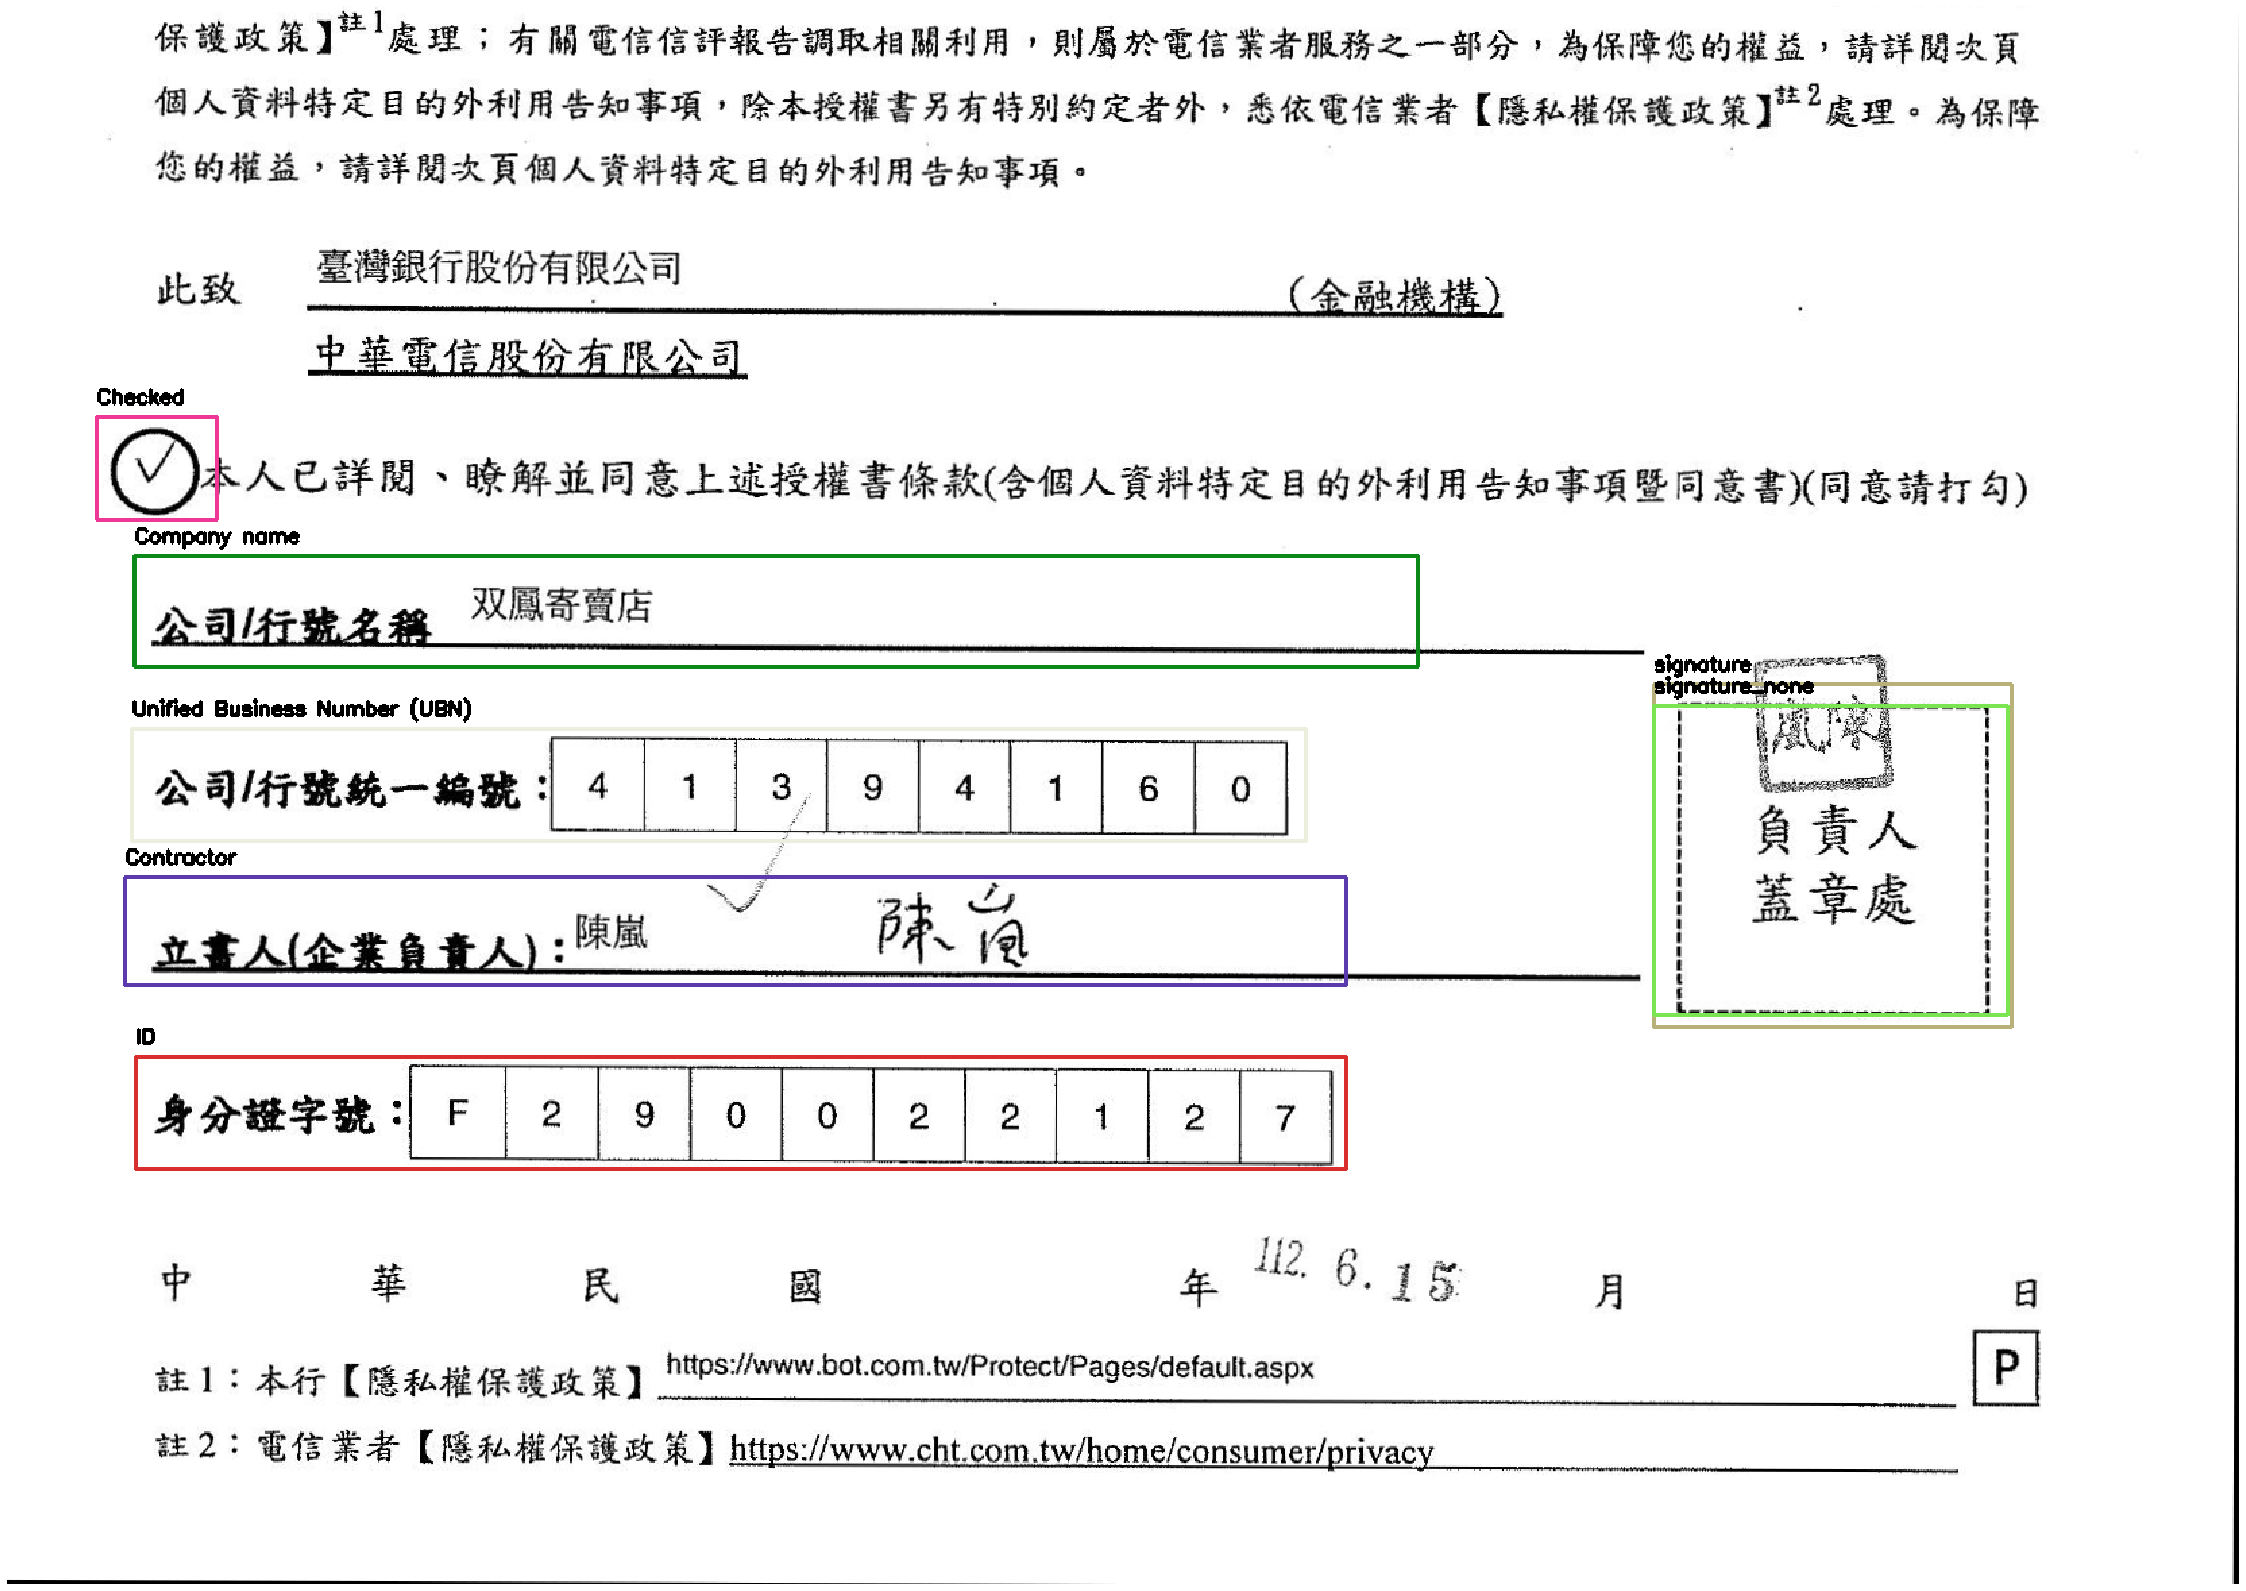

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 x1, y1, x2, y2, conf, class_id 1346.2882 106.681206 1501.1478 240.1534 0.9711385 signature_none
 x1, y1, x2, y2, conf, class_id 104.16648 135.63597 190.52826 207.16542 0.9687347 Unchecked
{'signature': {'class_id': 'signature_none', 'conf': 0.9711385}, 'Unchecked': {'class_id': 'Unchecked', 'conf': 0.9687347}}
signature_none 0.9711385
Unchecked 0.9687347


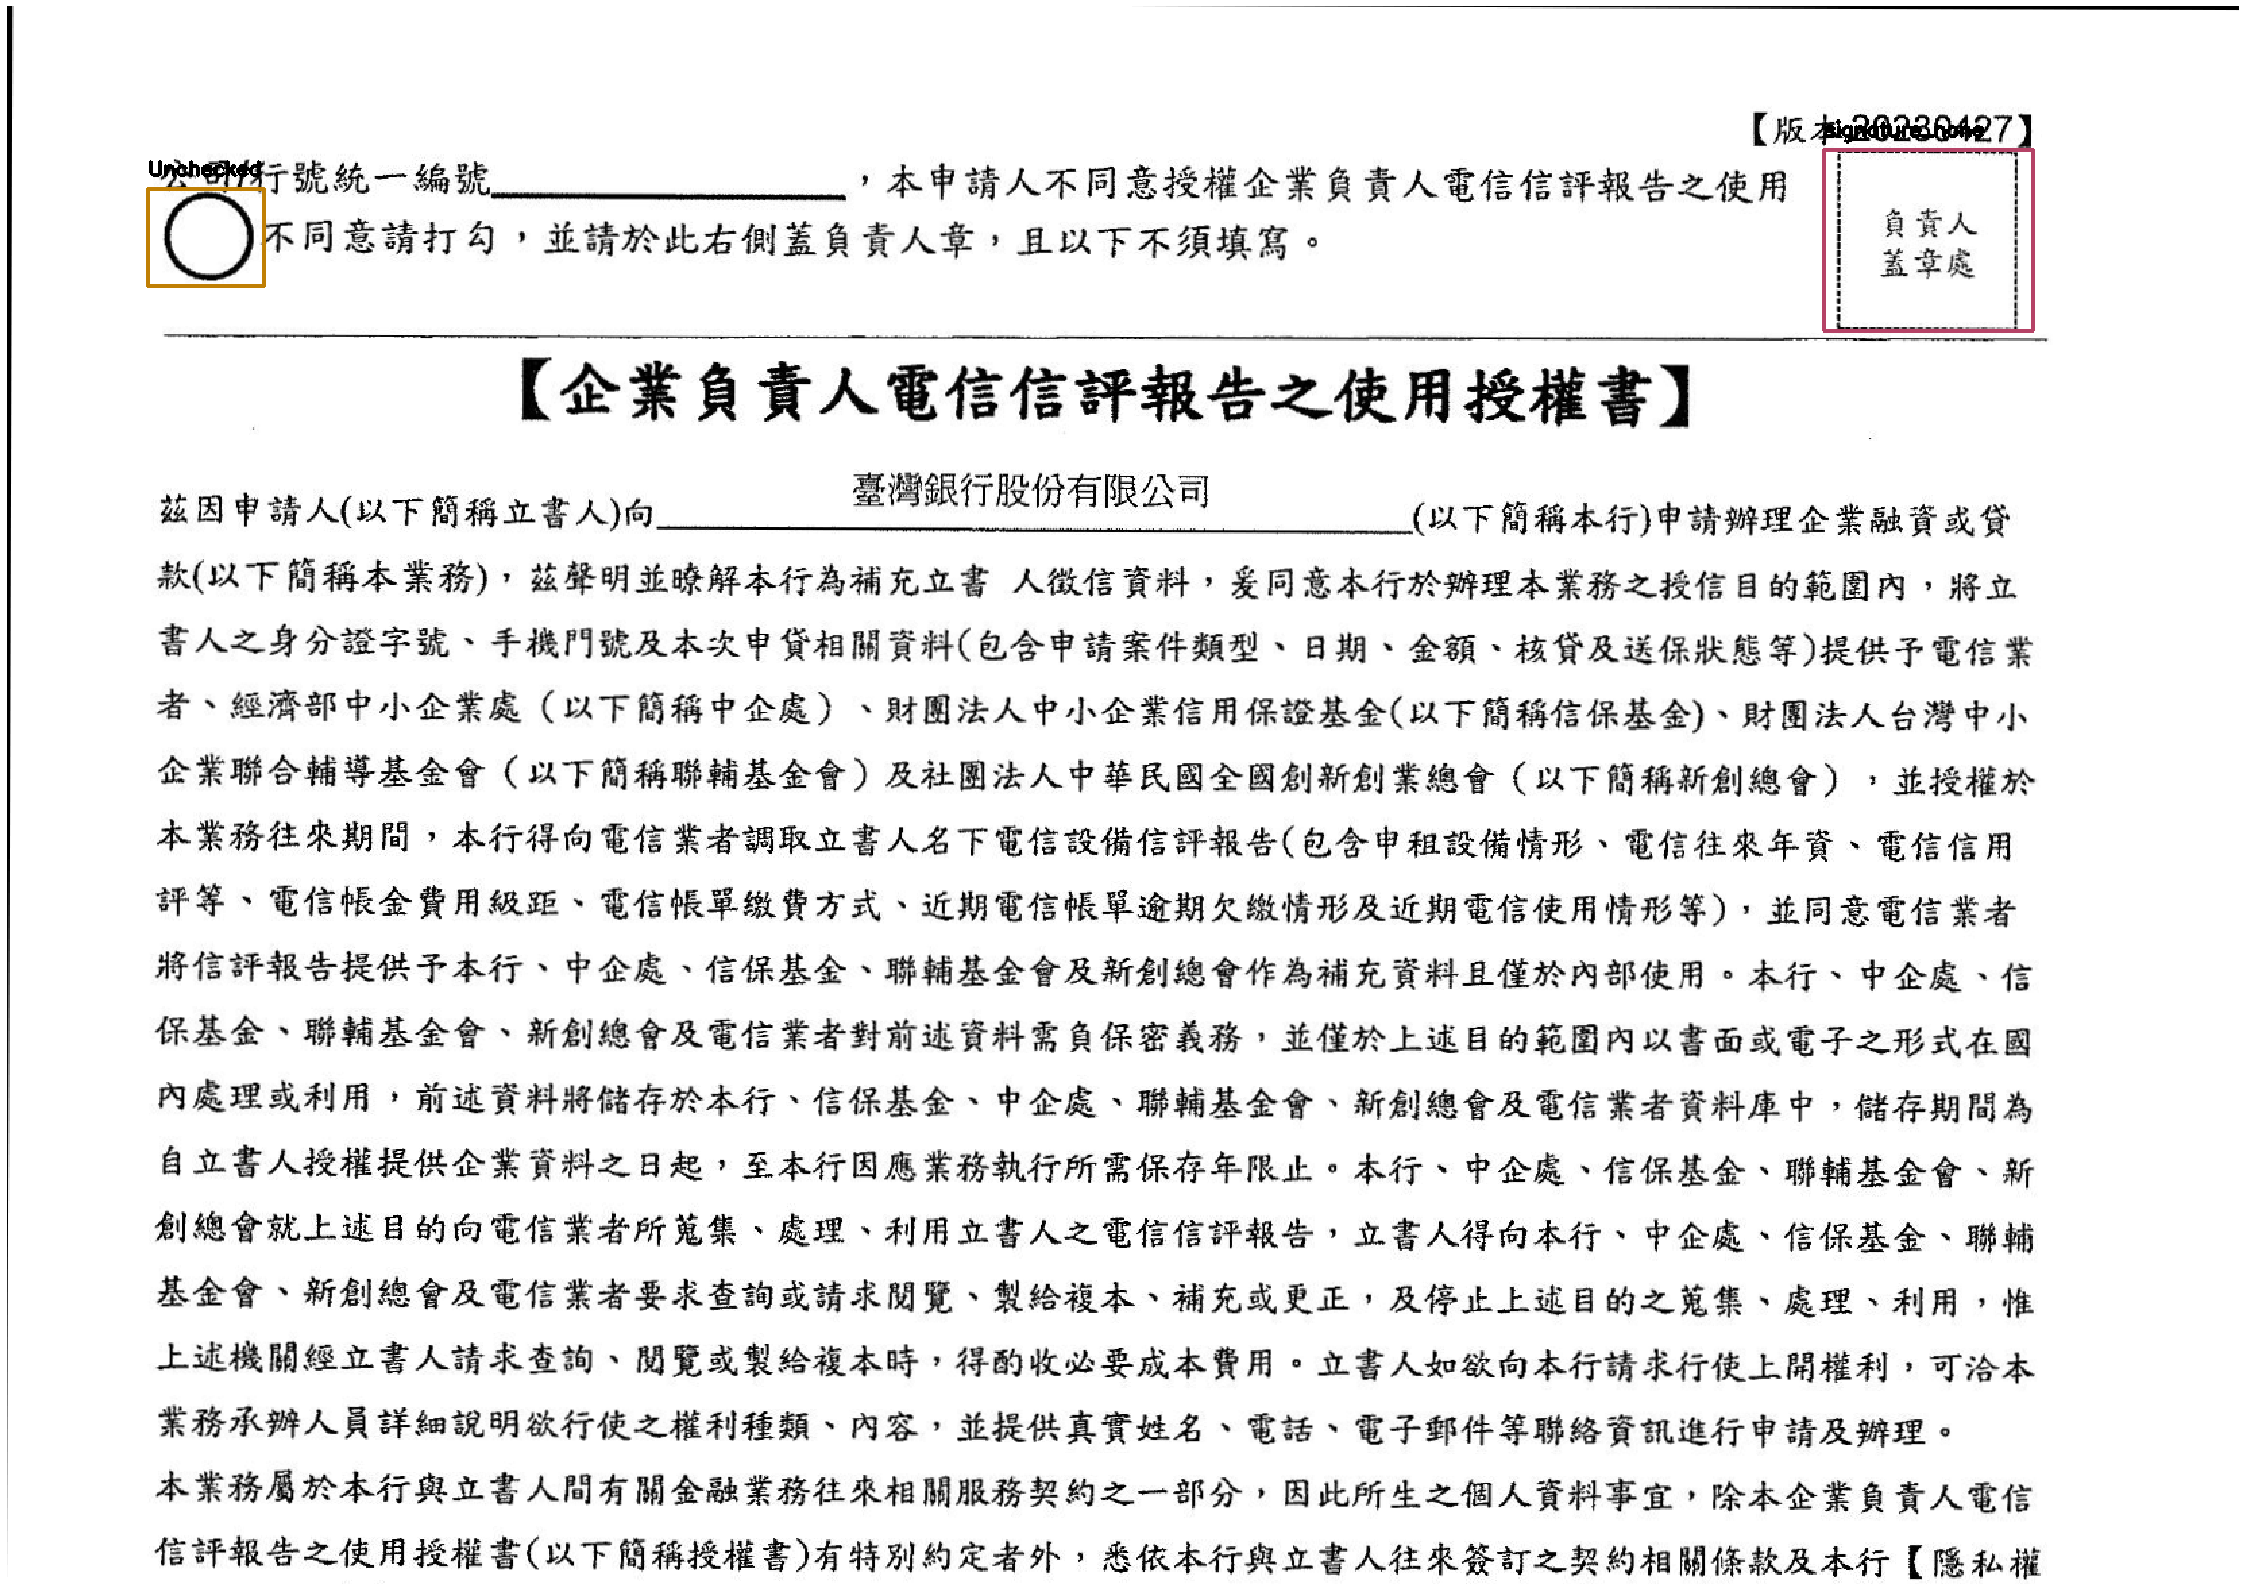

['signature_none', 'Unchecked']

In [99]:
# 對照範例樣本有歪斜會自動翻轉
corrected_image = correct_rotation(r'datasets/test/P_signature.jpg', P_template_path)
# 圖片對半裁剪只留下半部
crop_bottom = crop_image_bottom_half(corrected_image)
# 負責人合約書模型
object_detection_contractor(crop_bottom,WEIGHTS_contractor_pt)

# 圖片對半裁剪只留上半部
crop_top = crop_image_top_half(corrected_image)
object_detection_contractor(crop_top,WEIGHTS_contractor_pt)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 x1, y1, x2, y2, conf, class_id 100.94308 650.0896 963.6104 745.7027 0.9850421 Contractor_none
 x1, y1, x2, y2, conf, class_id 103.082115 536.514 964.82837 632.2976 0.98415124 Unified Business Number (UBN)_none
 x1, y1, x2, y2, conf, class_id 1226.9558 517.00323 1487.0145 760.5376 0.9829472 signature_none
 x1, y1, x2, y2, conf, class_id 105.27948 784.4094 996.8982 873.7982 0.97923636 ID_none
 x1, y1, x2, y2, conf, class_id 74.9804 316.41837 159.53859 387.5538 0.97832185 Unchecked
 x1, y1, x2, y2, conf, class_id 97.47801 416.36472 1206.4836 507.40582 0.9730876 Company name_none


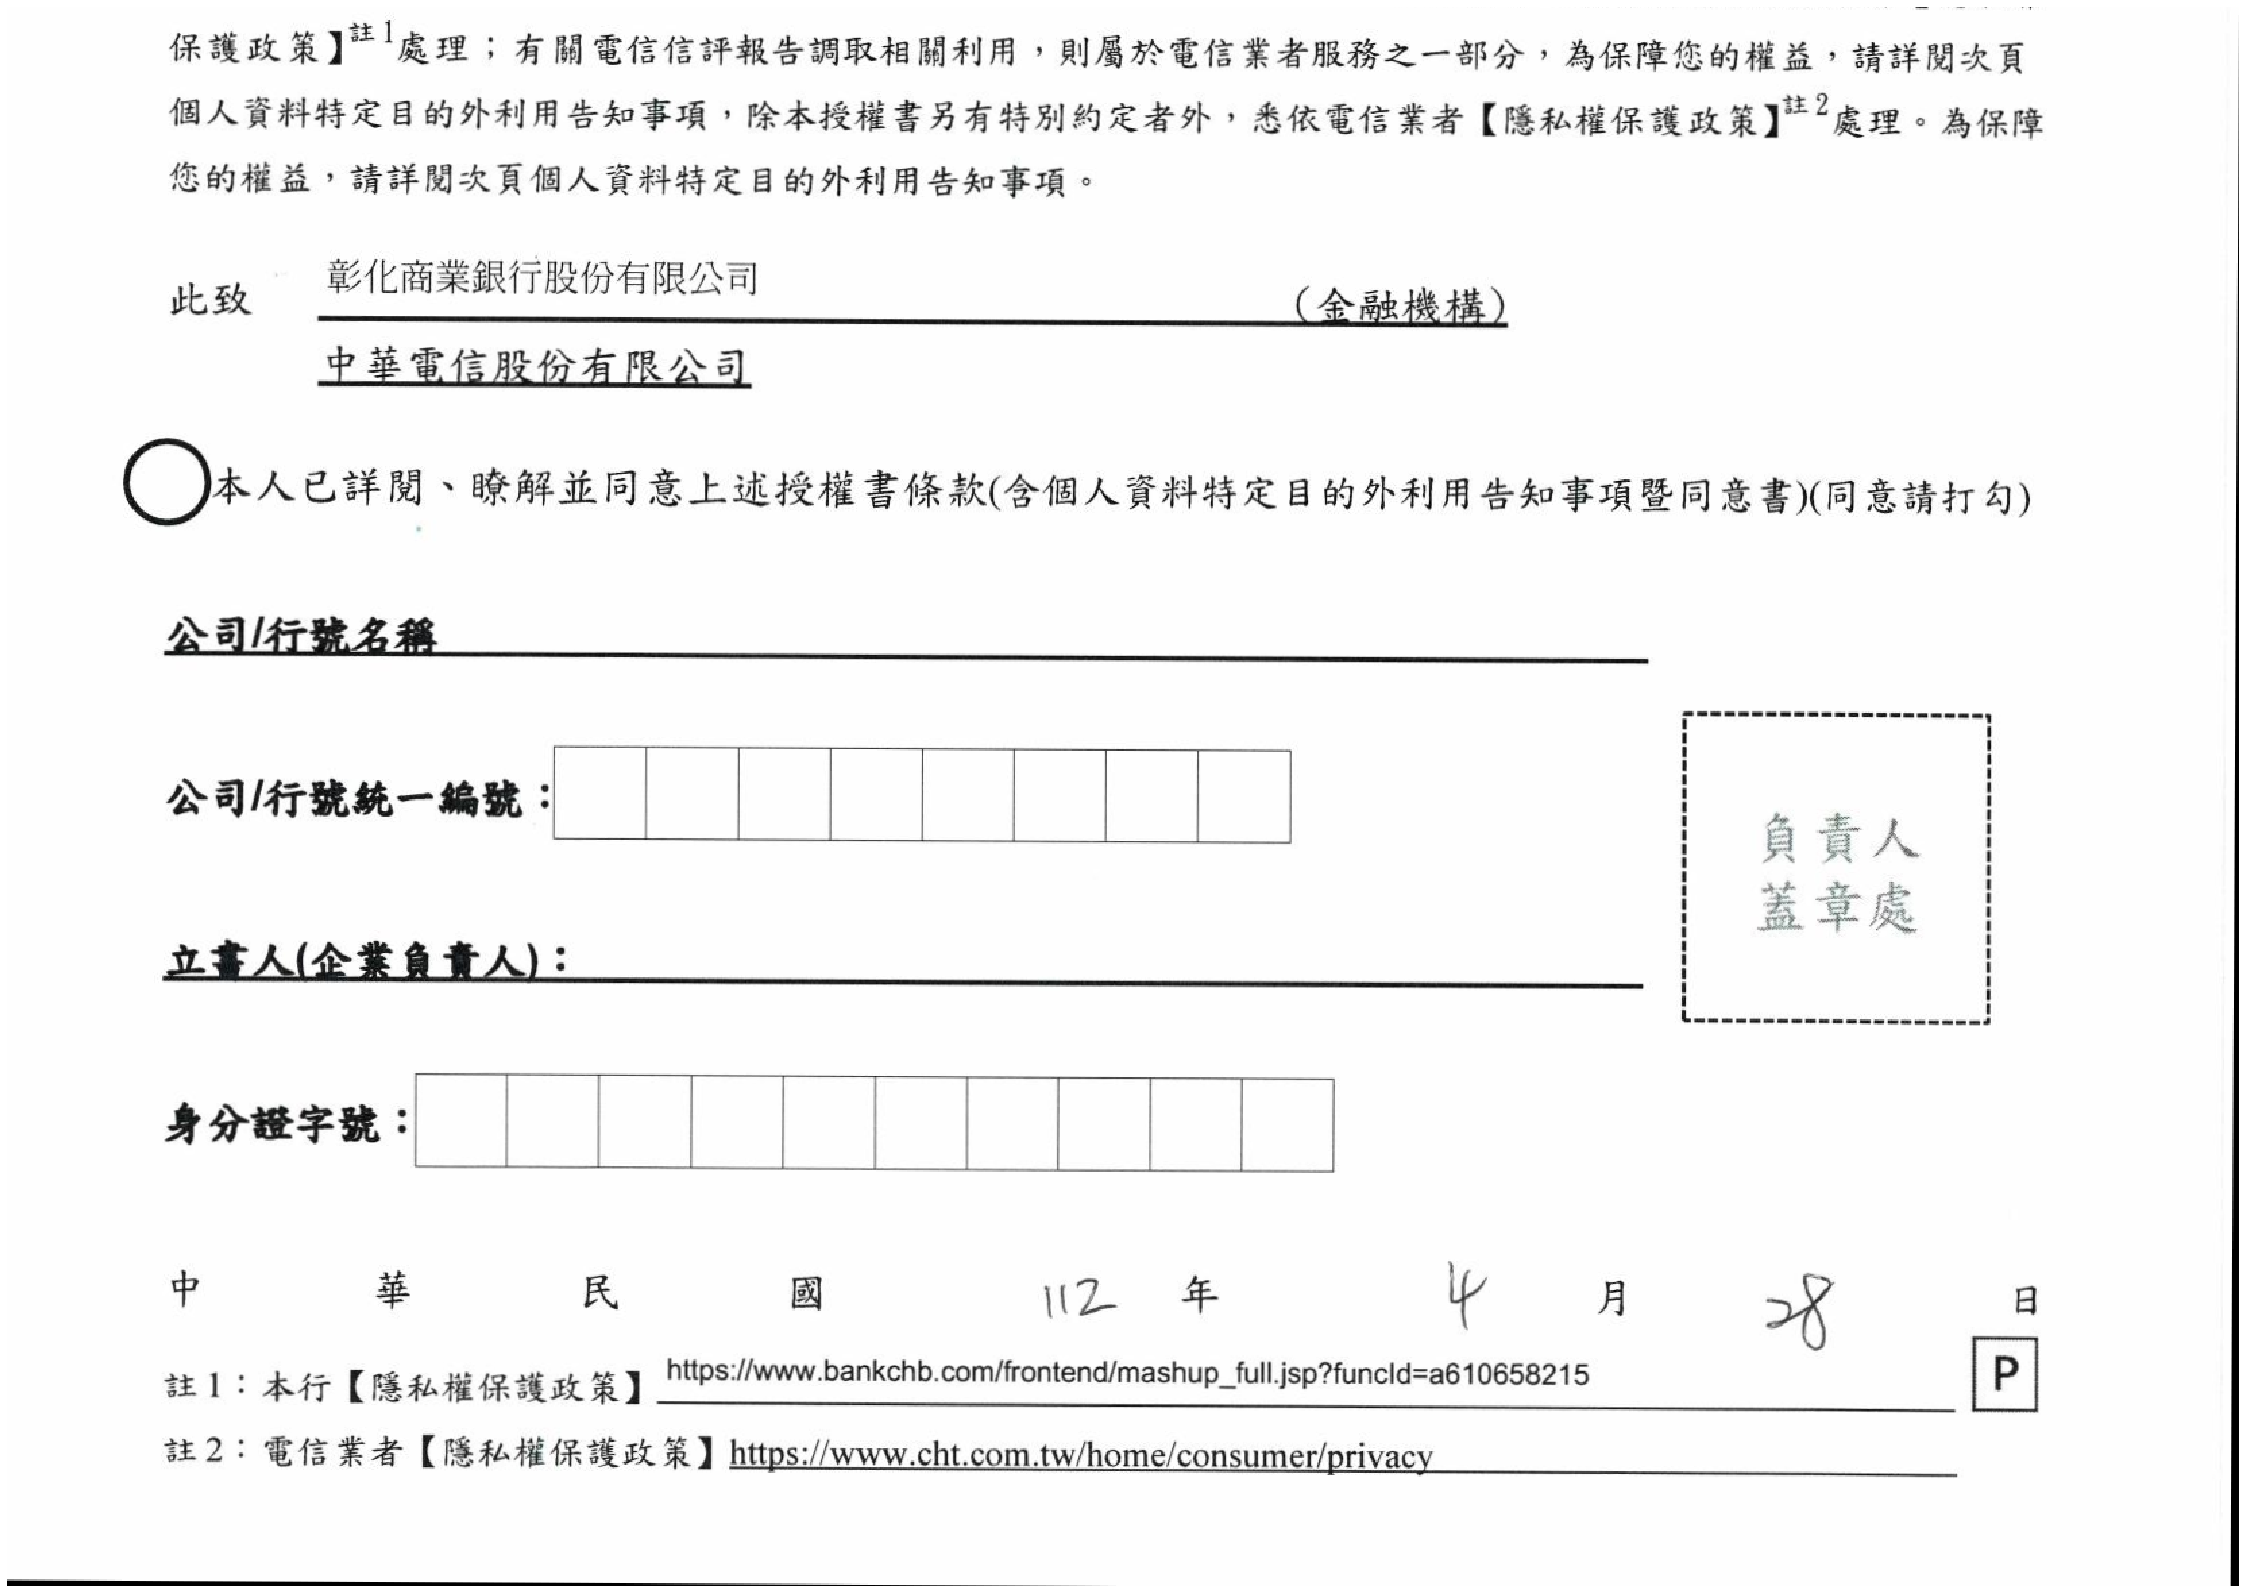

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 x1, y1, x2, y2, conf, class_id 1353.0679 112.030876 1506.8379 250.31256 0.97097343 signature
 x1, y1, x2, y2, conf, class_id 111.47518 129.38054 207.26047 212.63376 0.92559946 Checked


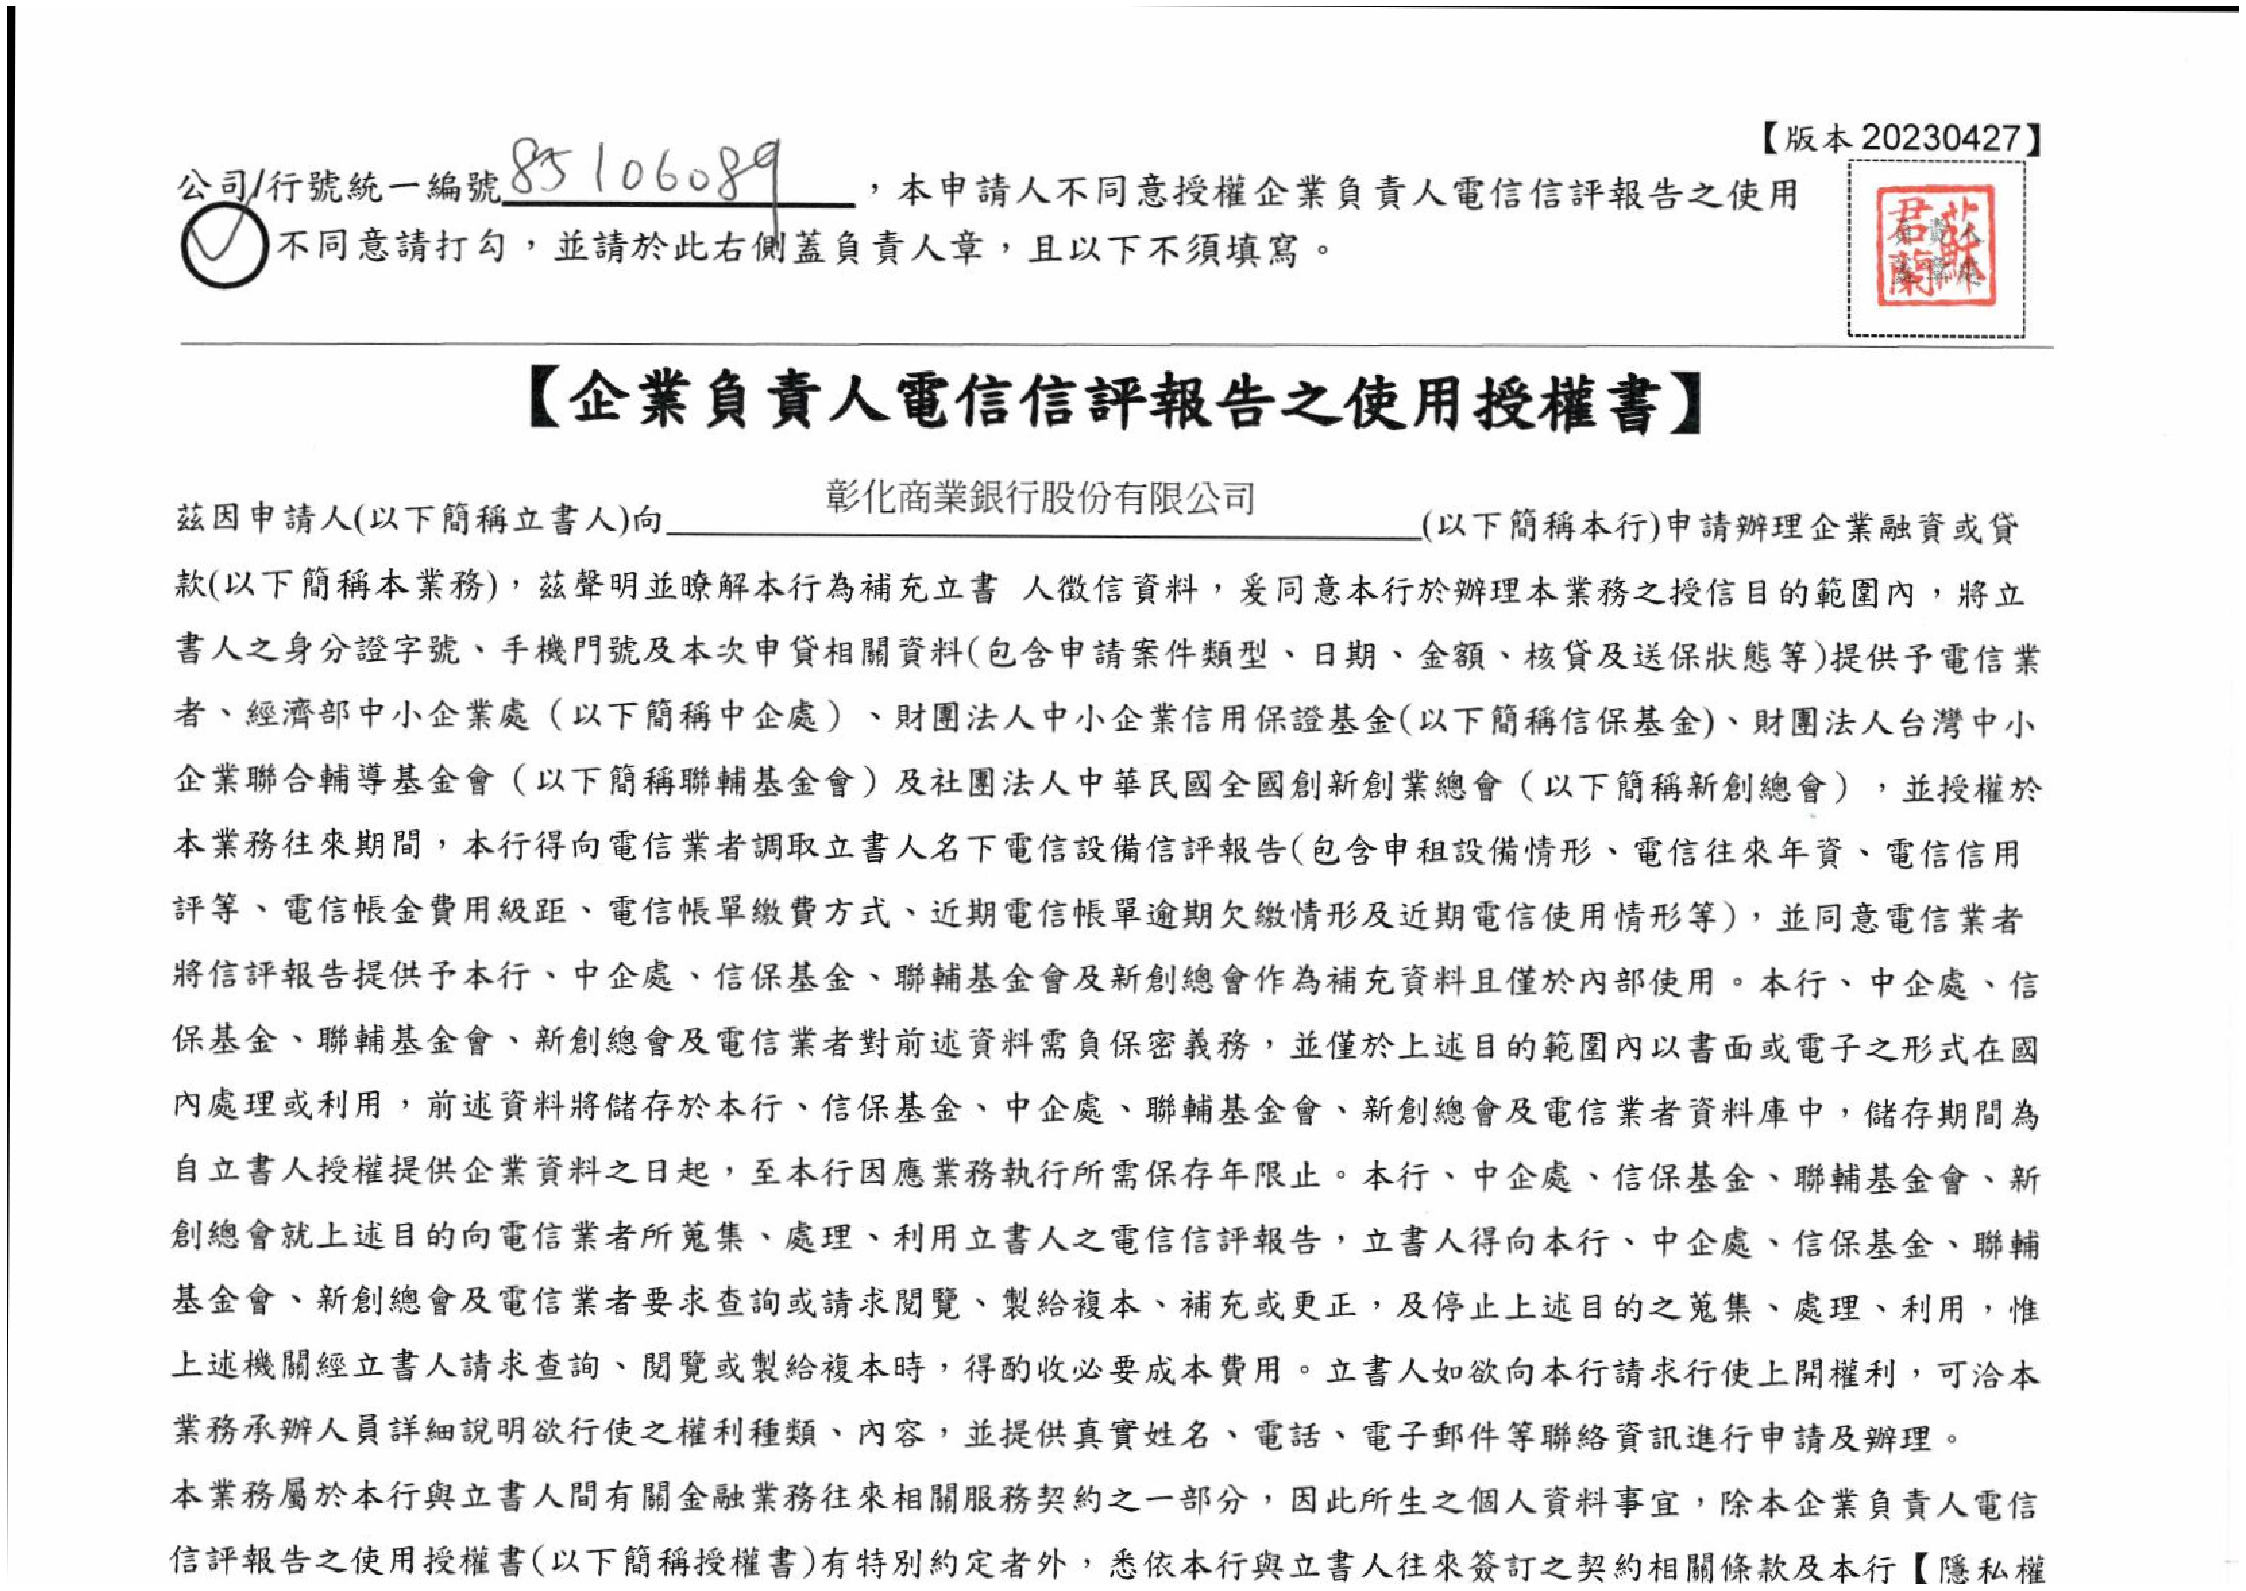

['signature', 'Checked']

In [41]:
# 對照範例樣本有歪斜會自動翻轉
corrected_image = correct_rotation(IMAGE_FILE_contractor, P_template_path)
# 圖片對半裁剪只留下半部
crop_bottom = crop_image_bottom_half(corrected_image)
# 負責人合約書模型
object_detection_contractor(crop_bottom,WEIGHTS_contractor_pt)

# 圖片對半裁剪只留上半部
crop_top = crop_image_top_half(corrected_image)
object_detection_contractor(crop_top,WEIGHTS_contractor_pt)

#### STEP3 數字辨識

#### STEP4 API串接最終function

In [18]:
def recognition_all(agree_type,IMAGE_FILE,company_id,rep_id,rotate_image=True):
    # 企業
    enterprise_output_result = {
    "agree_type_final":"1", 
    "ocr_agree_check":-1, #是否勾選同意 1:辨識有勾選 0:辨識未勾選 -1:未辨識 Checked/Unchecked
    "ocr_big_seal":-1, #是否蓋大章 big/big_none
    "ocr_small_seal":-1, #是否蓋小章 small/small_none
    #"ocr_bank":None, #授權銀行
    "ocr_comp_id_check":-1, #是否有填統一編號、是否與查詢對象相符 0:未填寫 1:有填寫且相符 2:有填寫但不符 -1:未辨識 Unified Business Number (UBN)/Unified Business Number (UBN)_none
    "ocr_comp_name":-1, #是否有填立書人(公司名) Company name/Company name_none
    "ocr_rep_name":-1, #是否有填代表人 Representative/Representative_none
    "status_code":"10000",
    "message":"agree"}

    # 負責人
    contractor_output_result = {
    "agree_type_final":"2",
    "ocr_agree_check":-1, #是否勾選同意 Checked/Unchecked
    "ocr_rep_seal":-1, #是否蓋負責人印章  signature/signature_none
    #"ocr_bank":None, #授權銀行
    "ocr_comp_name":-1, #是否有公司/行號名稱 Company name/Company name_none
    "ocr_comp_id_check":-1, #是否有填統一編號、是否與查詢對象相符 0:未填寫 1:有填寫且相符 2:有填寫但不符 -1:未辨識 Unified Business Number (UBN)/Unified Business Number (UBN)_none
    "ocr_rep_name":-1, #是否有填立書人(企業負責人)  Contractor/Contractor_none
    "ocr_rep_id_check":-1, # 是否有填身分證字號、是否與查詢對象相符 0:未填寫 1:有填寫且相符 2:有填寫但不符 -1:未辨識  ID/ID_none
    "status_code":"10000",
    "message":"agree"}

    # CLASSES = [ 'big','big_none','small','small_none','signature','signature_none','Checked',
    # 'Unchecked','Contractor','Contractor_none','Representative','Representative_none',
    # 'Company name','Company name_none','Bank name','Unified Business Number (UBN)','Unified Business Number (UBN)_none',
    # 'ID','ID_none','codes','codes_none' ]


   # 根據agree_type的值進行相應的處理
    if agree_type == 1:
        # 顛倒確認
        # 企業授權書辨識邏輯
        if classification(IMAGE_FILE,type_recognition_pth)[0] == 'enterprise' and classification(IMAGE_FILE,type_recognition_pth)[1] > 0.9 :
            # # 對照範例樣本有歪斜會自動翻轉
            if rotate_image:
                corrected_image = correct_rotation(IMAGE_FILE, E_template_path)
            else:
                corrected_image = cv2.imread(IMAGE_FILE)
            # 圖片對半裁剪只留下半部
            crop_img = crop_image_bottom_half(corrected_image)
            # 企業合約書模型
            obd_result = object_detection_enterprise(crop_img,WEIGHTS_enterprise_pt)
            if "Unchecked" in obd_result:
                enterprise_output_result["ocr_agree_check"] = 0
                # 同意授權部分未打勾  不同意授權部分打勾
                crop_img_top = crop_image_top_half(corrected_image)
                disagree_result = object_detection_enterprise(crop_img_top,WEIGHTS_enterprise_pt)
                if "Checked" in disagree_result:
                    return {"agree_type_final":"1","message":"disagree"}
            elif "Checked" in obd_result:
                enterprise_output_result["ocr_agree_check"] = 1
            if "big_none" in obd_result:
                enterprise_output_result["ocr_big_seal"] = 0
            elif "big" in obd_result:
                enterprise_output_result["ocr_big_seal"] = 1
            if "small_none" in obd_result:
                enterprise_output_result["ocr_small_seal"] = 0
            elif "small" in obd_result:
                enterprise_output_result["ocr_small_seal"] = 1                
            if "Unified Business Number (UBN)_none" in obd_result:
                enterprise_output_result["ocr_comp_id_check"] = 0
            elif "Unified Business Number (UBN)" in obd_result:
                enterprise_output_result["ocr_comp_id_check"] = 1
            # else: #辨識的數字比對
            #     if company_id == 
            if "Company name_none" in obd_result:
                enterprise_output_result["ocr_comp_name"] = 0
            elif "Company name" in obd_result:
                enterprise_output_result["ocr_comp_name"] = 1
            if "Representative_none" in obd_result:
                enterprise_output_result["ocr_rep_name"] = 0
            elif "Representative" in obd_result:
                enterprise_output_result["ocr_rep_name"] = 1
            # 回傳辨識狀況
            values = enterprise_output_result.values()
            if all(value == -1 or value == 0 for value in values if isinstance(value, (int, float))):
                enterprise_output_result["status_code"] = "10003"
                enterprise_output_result["message"] = "All items error, please upload again"
                # 保存錯誤的圖片
                save_error_image(crop_img,IMAGE_FILE, folder_name="all_error")
                return enterprise_output_result
            elif any(value == -1 or value == 0 for value in values if isinstance(value, (int, float))):
                enterprise_output_result["status_code"] = "10004"
                enterprise_output_result["message"] = "Partial items error, please check manually"
                # 保存錯誤的圖片
                save_error_image(crop_img,IMAGE_FILE, folder_name="partial_error")
                return enterprise_output_result
            else:
                return enterprise_output_result
        else:
            # 將錯誤訊息寫入 log 檔
            logging.error("[%s] 授權書類型錯誤" %  current_time )
            return {"status_code":"10002",
                    "message":"Agree type error",
                    "agree_type_final":None}
    elif agree_type == 2:
        # 負責人授權書辨識邏輯
        if  classification(IMAGE_FILE,type_recognition_pth)[0] == 'contractor' and classification(IMAGE_FILE,type_recognition_pth)[1] > 0.9 :
            # # 對照範例樣本有歪斜會自動翻轉
            if rotate_image:
                corrected_image = correct_rotation(IMAGE_FILE, P_template_path)
            else:
                corrected_image = cv2.imread(IMAGE_FILE)
            # 圖片對半裁剪只留下半部
            crop_img = crop_image_bottom_half(corrected_image)
            # 企業合約書模型
            obd_result = object_detection_contractor(crop_img,WEIGHTS_contractor_pt)
            if "Unchecked" in obd_result:
                contractor_output_result["ocr_agree_check"] = 0
                # 同意授權部分未打勾  不同意授權部分打勾
                crop_img_top = crop_image_top_half(corrected_image)
                disagree_result = object_detection_contractor(crop_img_top,WEIGHTS_contractor_pt)
                if "Checked" in disagree_result:
                    return {"agree_type_final":"2","message":"disagree"}
            elif "Checked" in obd_result:
                contractor_output_result["ocr_agree_check"] = 1
            if "signature_none" in obd_result:
                contractor_output_result["ocr_rep_seal"] = 0
            elif "signature" in obd_result:
                contractor_output_result["ocr_rep_seal"] = 1
            if "Company name_none" in obd_result:
                contractor_output_result["ocr_comp_name"] = 0
            elif "Company name" in obd_result:
                contractor_output_result["ocr_comp_name"] = 1
            if "Unified Business Number (UBN)_none" in obd_result:
                contractor_output_result["ocr_comp_id_check"] = 0
            elif "Unified Business Number (UBN)" in obd_result:
                contractor_output_result["ocr_comp_id_check"] = 1
            if "Contractor_none" in obd_result:
                contractor_output_result["ocr_rep_name"] = 0
            elif "Contractor" in obd_result:
                contractor_output_result["ocr_rep_name"] = 1
            if "ID_none" in obd_result:
                contractor_output_result["ocr_rep_id_check"] = 0
            elif "ID" in obd_result:
                contractor_output_result["ocr_rep_id_check"] = 1
            # 回傳辨識狀況
            values = contractor_output_result.values()
            if all(value == -1 or value == 0 for value in values if isinstance(value, (int, float))):
                contractor_output_result["status_code"] = "10003"
                contractor_output_result["message"] = "All items error, please upload again"
                # 保存錯誤的圖片
                save_error_image(crop_img,IMAGE_FILE, folder_name="all_error")
                return contractor_output_result
            elif any(value == -1 or value == 0 for value in values if isinstance(value, (int, float))):
                contractor_output_result["status_code"] = "10004"
                contractor_output_result["message"] = "Partial items error, please check manually"
                # 保存錯誤的圖片
                save_error_image(crop_img,IMAGE_FILE, folder_name="partial_error")                
                return contractor_output_result
            else:
                return contractor_output_result
        else:
            # 將錯誤訊息寫入 log 檔
            logging.error("[%s] 授權書類型錯誤" %  current_time )
            # 保存錯誤的圖片         
            return {"status_code":"10002",
                    "message":"Agree type error",
                    "agree_type_final":None}
    elif agree_type == 3:
        print(classification(IMAGE_FILE,type_recognition_pth))
        # AI辨識辨識邏輯
        if   classification(IMAGE_FILE,type_recognition_pth)[0] == 'enterprise' and classification(IMAGE_FILE,type_recognition_pth)[1] > 0.9:
            # # 對照範例樣本有歪斜會自動翻轉
            if rotate_image:
                corrected_image = correct_rotation(IMAGE_FILE, E_template_path)
            else:
                corrected_image = cv2.imread(IMAGE_FILE)
            # 圖片對半裁剪只留下半部
            crop_img = crop_image_bottom_half(corrected_image)
            # 企業合約書模型
            obd_result = object_detection_enterprise(crop_img,WEIGHTS_enterprise_pt)
            if "Unchecked" in obd_result:
                enterprise_output_result["ocr_agree_check"] = 0
                # 同意授權部分未打勾  不同意授權部分打勾
                crop_img_top = crop_image_top_half(corrected_image)
                disagree_result = object_detection_enterprise(crop_img_top,WEIGHTS_enterprise_pt)
                if "Checked" in disagree_result:
                    return {"agree_type_final":"1","message":"disagree"}
            elif "Checked" in obd_result:
                enterprise_output_result["ocr_agree_check"] = 1
            if "big_none" in obd_result:
                enterprise_output_result["ocr_big_seal"] = 0
            elif "big" in obd_result:
                enterprise_output_result["ocr_big_seal"] = 1
            if "small_none" in obd_result:
                enterprise_output_result["ocr_small_seal"] = 0
            elif "small" in obd_result:
                enterprise_output_result["ocr_small_seal"] = 1                
            if "Unified Business Number (UBN)_none" in obd_result:
                enterprise_output_result["ocr_comp_id_check"] = 0
            elif "Unified Business Number (UBN)" in obd_result:
                enterprise_output_result["ocr_comp_id_check"] = 1
            # else: #辨識的數字比對
            #     if company_id == 
            if "Company name_none" in obd_result:
                enterprise_output_result["ocr_comp_name"] = 0
            elif "Company name" in obd_result:
                enterprise_output_result["ocr_comp_name"] = 1
            if "Representative_none" in obd_result:
                enterprise_output_result["ocr_rep_name"] = 0
            elif "Representative" in obd_result:
                enterprise_output_result["ocr_rep_name"] = 1
            # 回傳辨識狀況
            values = enterprise_output_result.values()
            if all(value == -1 or value == 0 for value in values if isinstance(value, (int, float))):
                enterprise_output_result["status_code"] = "10003"
                enterprise_output_result["message"] = "All items error, please upload again"
                # 保存錯誤的圖片
                save_error_image(crop_img,IMAGE_FILE, folder_name="all_error")
                return enterprise_output_result
            elif any(value == -1 or value == 0 for value in values if isinstance(value, (int, float))):
                enterprise_output_result["status_code"] = "10004"
                enterprise_output_result["message"] = "Partial items error, please check manually"
                # 保存錯誤的圖片
                save_error_image(crop_img,IMAGE_FILE, folder_name="partial_error")                
                return enterprise_output_result
            else:
                return enterprise_output_result
        elif classification(IMAGE_FILE,type_recognition_pth)[0] == 'contractor' and classification(IMAGE_FILE,type_recognition_pth)[1] > 0.9:
            # # 對照範例樣本有歪斜會自動翻轉
            if rotate_image:
                corrected_image = correct_rotation(IMAGE_FILE, P_template_path)
            else:
                corrected_image = cv2.imread(IMAGE_FILE)
            # 圖片對半裁剪只留下半部
            crop_img = crop_image_bottom_half(corrected_image)
            # 企業合約書模型
            obd_result = object_detection_contractor(crop_img,WEIGHTS_contractor_pt)
            #print(obd_result)
            if "Unchecked" in obd_result:
                contractor_output_result["ocr_agree_check"] = 0
                # 同意授權部分未打勾  不同意授權部分打勾
                crop_img_top = crop_image_top_half(corrected_image)
                disagree_result = object_detection_contractor(crop_img_top,WEIGHTS_contractor_pt)
                if "Checked" in disagree_result:
                    return {"agree_type_final":"2","message":"disagree"}
            elif "Checked" in obd_result:
                contractor_output_result["ocr_agree_check"] = 1
            if "signature_none" in obd_result:
                contractor_output_result["ocr_rep_seal"] = 0
            elif "signature" in obd_result:
                contractor_output_result["ocr_rep_seal"] = 1
            if "Company name_none" in obd_result:
                contractor_output_result["ocr_comp_name"] = 0
            elif "Company name" in obd_result:
                contractor_output_result["ocr_comp_name"] = 1
            if "Unified Business Number (UBN)_none" in obd_result:
                contractor_output_result["ocr_comp_id_check"] = 0
            elif "Unified Business Number (UBN)" in obd_result:
                contractor_output_result["ocr_comp_id_check"] = 1
            if "Contractor_none" in obd_result:
                contractor_output_result["ocr_rep_name"] = 0
            elif "Contractor" in obd_result:
                contractor_output_result["ocr_rep_name"] = 1
            if "ID_none" in obd_result:
                contractor_output_result["ocr_rep_id_check"] = 0
            elif "ID" in obd_result:
                contractor_output_result["ocr_rep_id_check"] = 1
            # 回傳辨識狀況
            values = contractor_output_result.values()
            if all(value == -1 or value == 0 for value in values if isinstance(value, (int, float))):
                contractor_output_result["status_code"] = "10003"
                contractor_output_result["message"] = "All items error, please upload again"
                # 保存錯誤的圖片
                save_error_image(crop_img,IMAGE_FILE, folder_name="all_error")
                return contractor_output_result
            elif any(value == -1 or value == 0 for value in values if isinstance(value, (int, float))):
                contractor_output_result["status_code"] = "10004"
                contractor_output_result["message"] = "Partial items error, please check manually"
                # 保存錯誤的圖片
                save_error_image(crop_img,IMAGE_FILE, folder_name="partial_error")
                return contractor_output_result
            else:
                return contractor_output_result
        else:
            # 將錯誤訊息寫入 log 檔
            logging.error("[%s] 授權書類型錯誤" %  current_time )
            # 保存錯誤的圖片
            return {"status_code":"10002",
                    "message":"Agree type error",
                    "agree_type_final":None}
    else:
        # 將錯誤訊息寫入 log 檔
        logging.error("[%s] 查詢參數有誤" %  current_time )
        return {"status_code":"30002",
                "message":"Parameter errors",
                "agree_type_final":None}

In [17]:
def agree_ai_check(agree_type,company_id,rep_id,location,agree_file_name):
    # 檢查參數格式是否正確
    if not isinstance(agree_type, int):
        logging.error("[%s] 查詢參數格式有誤" %  current_time )
        return {"status_code": "30001", "message": "Parameter errors","agree_type_final":None}
    if not isinstance(company_id, str):
        logging.error("[%s] 查詢參數格式有誤" %  current_time )
        return {"status_code": "30001", "message": "Parameter errors","agree_type_final":None}
    if not isinstance(rep_id, str):
        logging.error("[%s] 查詢參數格式有誤" %  current_time )
        return {"status_code": "30001", "message": "Parameter errors","agree_type_final":None}
    if not isinstance(location, str):
        logging.error("[%s] 查詢參數格式有誤" %  current_time )
        return {"status_code": "30001", "message": "Parameter errors","agree_type_final":None}
    if not isinstance(agree_file_name, str):
        logging.error("[%s] 查詢參數格式有誤" %  current_time )
        return {"status_code": "30001", "message": "Parameter errors","agree_type_final":None}

    if len(os.listdir(location))>0: # 確認資料夾內是否有檔案
        file_name_path = os.path.join(location, agree_file_name)
        if os.path.isfile(file_name_path): # 判斷是否為檔案
            # 使用 os.path.splitext() 函式來取得檔案的檔名 & 副檔名
            file_name = os.path.splitext(agree_file_name)[0]
            file_extension = os.path.splitext(agree_file_name)[1]
            # 根據副檔名進行判斷，並拼接檔案路徑
            # 1.pdf
            if file_extension == ".pdf":
                # 建立暫存資料夾
                temp_folder_name = "temp_images"
                # 檢查資料夾是否存在
                if os.path.exists(temp_folder_name):
                    # 若資料夾已存在，先刪除
                    shutil.rmtree(temp_folder_name)
                # 建立新資料夾
                os.makedirs(temp_folder_name)
                # 讀取 PDF 檔案
                with open(file_name_path, "rb") as file:
                    pdf_reader = PdfReader(file)
                    page_count = len(pdf_reader.pages)  # 獲取頁數
                # 頁數為一頁
                if page_count == 1:
                    images = convert_from_path(file_name_path, last_page=1)
                    if images:
                        image = images[0]  # 取得第一頁影像
                        image_name = '{}.jpg'.format(file_name)
                        output_file_path = os.path.join(temp_folder_name, image_name)
                        image.save(output_file_path, 'JPEG')
                        result = recognition_all(agree_type,IMAGE_FILE=output_file_path,company_id=company_id,rep_id=rep_id)   # 回傳辨識結果
                        #暫存資料夾刪除
                        shutil.rmtree(temp_folder_name)
                        return result
                    else:
                        logging.error("錯誤：無法讀取 PDF 檔案")
                        print("無法讀取 PDF 檔案")
                        return {"status_code":"10006",
                                "message":"Unable to read the PDF file",
                                "agree_type_final":None}
                # 判斷頁數是否超過一頁
                elif page_count > 1:
                    result_list = []
                    # 1.PDF 轉 jpg
                    # 逐頁轉換為 JPG
                    for page_number in range(page_count):
                        # 設定輸出檔案名稱
                        image_name = '{}_{}.jpg'.format(file_name, page_number+1)
                        output_file_path = os.path.join(temp_folder_name, image_name)

                        # 使用 convert_from_path 進行轉換
                        images = convert_from_path(file_name_path, first_page=page_number+1, last_page=page_number+1)

                        # 儲存圖像
                        if images:
                            images[0].save(output_file_path, 'JPEG')
                        else:
                            logging.error("錯誤：無法讀取 PDF 檔案")
                            print("無法讀取 PDF 檔案")
                            return {"status_code":"10006",
                                    "message":"Unable to read the PDF file",
                                    "agree_type_final":None}
                        result = recognition_all(agree_type,IMAGE_FILE=output_file_path,company_id=company_id,rep_id=rep_id)   # 回傳辨識結果
                        result_list.append(result)                        
                    #暫存資料夾刪除
                    shutil.rmtree(temp_folder_name)
                    return result_list

            # 2.tiff
            elif file_extension in [".tif", ".tiff"]:
                # 建立暫存資料夾
                temp_folder_name = "temp_images"
                # 檢查資料夾是否存在
                if os.path.exists(temp_folder_name):
                    # 若資料夾已存在，先刪除
                    shutil.rmtree(temp_folder_name)
                # 建立新資料夾
                os.makedirs(temp_folder_name)
                # 讀取 TIFF 檔案並轉換為多張 JPG 圖片
                convert_multi_page_tiff(file_name_path, os.path.join(temp_folder_name, file_name))
                result_list = []
                # 逐一辨識轉換後的 JPG 圖片
                for i in range(1, count_tiff_pages(file_name_path) + 1):
                    jpg_file_path = os.path.join(temp_folder_name, f"{file_name}_{i}.jpg")
                    result = recognition_all(agree_type, IMAGE_FILE=jpg_file_path, company_id=company_id,
                                             rep_id=rep_id,rotate_image=False)  # 回傳辨識結果
                    result_list.append(result)
                # 暫存資料夾刪除
                shutil.rmtree(temp_folder_name)
                return result_list
            # 3.jpg jpeg
            elif file_extension in [".jpg", ".jpeg"]:
                result = recognition_all(agree_type,IMAGE_FILE=file_name_path,company_id=company_id,rep_id=rep_id)   # 回傳辨識結果
                #print(result)
                return result
            # 4.png
            elif file_extension == ".png":
                result = recognition_all(agree_type,IMAGE_FILE=file_name_path,company_id=company_id,rep_id=rep_id)   # 回傳辨識結果
                #print(result)
                return result
            else:
                # 將錯誤訊息寫入 log 檔
                logging.error("[%s] 副檔名有誤，未知的檔案類型: {}".format(file_extension) %  current_time )
                # 顯示警告訊息
                print("警告：副檔名有誤，未知的檔案類型: {}".format(file_extension))
                return {"status_code":"10005",
                        "message":"Unknown file type",
                        "agree_type_final":None}
    else:
        # 將錯誤訊息寫入 log 檔
        logging.error("[%s] 資料夾內沒有檔案" %  current_time )
        # 顯示警告訊息
        print("警告：資料夾內沒有檔案")
        return {"status_code":"10001",
                "message":"Agree file not found",
                "agree_type_final":None}

In [19]:
agree_ai_check(agree_type=3,company_id="123", rep_id="123", location='datasets/temp', agree_file_name="fsB3100420230629002470_0_0-2.pdf")

('contractor', 0.6981756)


{'status_code': '10002',
 'message': 'Agree type error',
 'agree_type_final': None}